# Probability Distribution Cookie Cutters in Python

In the spirit of Valentine's Day, we at Fast Forward Labs thought it would be fun to bake cookies for our sweethearts. Being DIY nerds, we thought we'd math it up a bit.

We used python's `numpy` library to generate probability distributions and `matplotlib` to check our disributions. Then we wrote a python function to generate a SCAD file defining three-dimensional shapes from the distributions. Using [OpenSCAD](OPENSCAD LINK), an open-source CAD program, we checked the 3D models and exported them to STL files for printing. We used a 5th Generation [MakerBot Replicator](MAKERBOT REP5 LINK) to print our 3D models. And we baked cookies.

Here's the process we used in case you want to make your own. We start with `numpy` to generate our distributions, and `matplotlib` so we can visualize the output.

In [36]:
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt

We chose a beta distribution because it's well behaved for purposes of making a 3D printed object. 
* A beta distribution only has values from 0 to 1. This gives us a fixed-width shape to work with. (Compare a Gaussian distribution, which has long tails on both sides.) 
* The area under the curve of a beta distribution is necessarily 1, which helps keep the shape from getting _too_ eccentric while allowing flexibility in choice of parameters, and thus a wider range of shapes.

First, we chose a number of bins, `numbins`, for our distribution. This value should be high enough to have a smooth curve, but low enough to not make it slow to render in OpenSCAD (and slower to 3D print). We also chose an odd-numbered value for `numbins` so our plot (and thus our shape) has a clear peak.

We used `numpy`'s `linspace` function to create a set of x-axis points. `linspace` gives us `X`, a set of `numpoints` points, evenly spaced between 0 and 1 (the domain of a beta distribution), that define the sample bins for our distribution.

We chose parameters for the beta distribution that make a nice, easily printable shape. You can adjust these parameters to get different shapes as you prefer.

In [37]:
# choose enough points to have a relatively smooth curve without 
# creating so many facets that the 3D printer is slow
#
# choose an odd number so there is a definitive peak to the curve
numpoints = 35

# set up linspace
X = np.linspace(0, 1, numpoints)

# beta distribution parameters
a, b = 2, 1.6

# get beta distribution array
betadist = beta.pdf(X, a, b)

For the sake of clarity, let's take a look at the values of our x-axis points in `X` and the values we get from our beta distribution in `betadist`. Note that each is `numpoints` long - `X` and `betadist` respectively give the x- and y-values for our plot.

In [38]:
print('X =\n', X)
print('betadist =\n', betadist)

X =
 [0.         0.02941176 0.05882353 0.08823529 0.11764706 0.14705882
 0.17647059 0.20588235 0.23529412 0.26470588 0.29411765 0.32352941
 0.35294118 0.38235294 0.41176471 0.44117647 0.47058824 0.5
 0.52941176 0.55882353 0.58823529 0.61764706 0.64705882 0.67647059
 0.70588235 0.73529412 0.76470588 0.79411765 0.82352941 0.85294118
 0.88235294 0.91176471 0.94117647 0.97058824 1.        ]
betadist =
 [0.         0.12018089 0.2359647  0.34726845 0.45400413 0.5560782
 0.65339098 0.74583603 0.83329938 0.9156586  0.9927818  1.06452643
 1.13073782 1.19124747 1.24587106 1.2944059  1.33662798 1.37228823
 1.40110782 1.42277236 1.43692427 1.44315298 1.44098179 1.4298501
 1.40908861 1.37788375 1.33522484 1.27982224 1.20997346 1.12332924
 1.016446   0.88381529 0.71531122 0.4866772  0.        ]


Next we do a quick plot of the distribution. This step isn't necessary, but gives us a preview of the shape of the cookie we're going to end up with.

We can also save the shape to a scalable vector graphics file (SVG) to inspect visually, or for use in other CAD programs, if you have one.

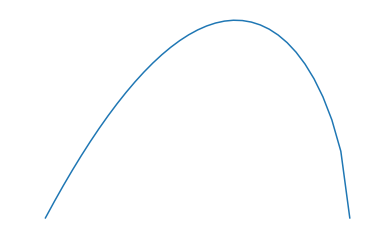

In [39]:
# turn off the axes so we only see the curve
plt.axis('off')

# plot the curve itself
plt.plot(X, betadist)

# save the SVG file - ending the filename with SVG is enough to set the type
plt.savefig('beta.svg')

Now we get to the meat of the job. The function below generates a `scad` file. This is a text file that defines objects and operations on objects, which OpenSCAD can use to render the objects.

There are two main parts to the `scad` file. The first defines the points of the polygon we're generating. The second performs some manipulation operations to generate a cookie-cutter-like 3D object from the polygon.

Here's how this `scad` code makes a cookie cutter. 
* Two polygons are generated from the points listed above. 
* One of those polygons is x-translated to be centered at origin (in this example, this is a translation of -0.5 because we know a beta distribtion ranges from 0 to 1), and then extruded into a 3D shape.
* The other polygon is scaled up a bit (to make the outer edge of the cookie cutter), then x-, y-, and z-translated such that the inner shape will "cut" through the middle of the outer shape at the subtraction operation.
* The inner shape is subtracted from the outer shape, leaving a cookie-cutter-like ring.

Note that `scad` file language uses a nested order of operations, and braces can be omitted for operations with only one parameter. So the output `scad` code should be read inside-to-outside, i.e., a polygon is generated, then translated, then extruded, then subtracted.

Note also that the values used for translating the objects are chosen for the specific shape of the disribution and parameters. Other disributions or parameters will require some tinkering in OpenSCAD to find values that render a cookie cutter well from _that_ distribution-parameter set. 

Of course it would be better to write code that handles the general case of any distribution and parameter set, but manufacturing physical objects still involves a fair bit of art to go along with its science and the shapes generated from distribution-parameter sets differ widely. Thus [there is no single cookie-cutter solution](https://img.buzzfeed.com/buzzfeed-static/static/2014-03/enhanced/webdr06/31/11/enhanced-19051-1396279602-6.jpg) for all distribution-parameter sets.

In [40]:
def make_openscad(X, Y, filename):
    
    # open a file to store our SCAD instructions
    with open(filename, "w+") as fd:
        
        # first, we define the polygon
        # build a string containing each point of the polygon (plot) describing the distribution
        points = ""
        for x, y in zip(X, Y):
            points += "\t[{}, {}],\n".format(x, y)
            
        # write the point string to the file in SCAD format
        fd.write("""
points = [
{}];""".format(points))
        
        # next, we write SCAD instructions to turn the polygon into 3D objects and arrange them as a cookie cutter
        # - create two solid shapes from the polygon points defined above 
        # - index the first shape over to center it on origin
        # - scale up the other shape a bit and index in three dimensions to surround the smaller polygon
        # - subtract the smaller shape from the larger shape, leaving a scaled up shape with a smaller-shape hole
        # - this should give us a cookie cutter
        fd.write("""
difference(){
    
// OUTER COOKIE CUTTER SHAPE
    
    // extrude the outer polygon into a 3D shape
    // this extrusion is thinner than the inner shape to make sure the inner shape "cuts" through it completely
    linear_extrude(0.4)
    
        // x- and y-shift the outer polygon to be roughly centered around the inner shape
        // z-shift the outer polygon so the extruded inner shape cuts all the way through
        translate([-0.54, -0.03, -0.1])
            
            // scale this polygon up a bit to make an outer ring of a cookie cutter
            scale(1.08, 1.08, 1.08)
            
                // generate a polygon to become the outer shape
                polygon(points);        
    
// INNER COOKIE CUTTER SHAPE TO BE SUBTRACTED FROM OUTER

    // extrude the inner polygon into a 3D shape
    // this extrusion is thicker than the outer shape to ensure the inner shape "cuts" completey through the outer shape
    // the "scale" parameter grows the shape as it extrudes to give the finished cutter a narrower edge
    linear_extrude(0.6, scale=1.08) 
    
        // x-shift the shape to 
        translate([-0.5, -0.012, 0]) //x-center the polygon at origin
            
            // generate a polygon to become the inner shape (this is effectively defining a hole)
            polygon(points);
}""")

# and now we run the function to make our SCAD file
make_openscad(X, betadist, "beta.scad")

Now we have a file to load into OpenSCAD. OpenSCAD will render this file for us in 3D and export it to a more print friendly format, `stl`.

First open the `scad` file in OpenSCAD. Click the render button or press F6 to render the file.

Zoom in to the file to inspect it to make sure it looks correct. At this point, make any adjustments you like, especially the x-, y-, and z-translations that define the relationships between the two shapes and thus define the shape of the cookie cutter.

This is what our model looked like when we were finished.

[SHOULD LOOK LIKE THIS? - ADD image below?](IMAGE LINK)


Once you have a shape that's suitably cookie-cutter-y, export the shape to an appropriate format for your 3D printer.  In our case, this was a stereolithography file, `stl` format (in OpenSCAD, File->Export->Export to STL).

We printed our cookie cutters at [NYC Resistor](http://www.nycresistor.com), our friendly Brooklyn hackerspace. It's an amazing place to learn, share, and make things (full disclosure: the Fast Forward Labs team includes NYC Resistor members 😉).

If you're using a MakerBot printer as we did, you'll need to install their software to make a printer-ready file.
* [MakerBot software for Windows and MacOS](https://www.makerbot.com/download-print/)
* [MakerBot software for Linux](https://support.makerbot.com/learn/makerbot-desktop-software/installation-and-setup/how-to-install-makerbot-desktop-for-linux_11262)

We used MakerBot Desktop for Ubuntu. It looked like this when we imported the `stl` file.

[MAKERBOT IMAGE](LINK TO MAKERBOT IMPORT)

At this point, you'll need to decide how big of a cookie cutter you want. We had to scale our model up a fair bit.

[MAKERBOT IMAGE](LINK TO MAKERBOT SCALE)

Note when you scale up the x and y dimensions, that you need not necessarily scale up the z dimension to match - a cookie cutter only needs to be a half inch or so tall.

From there, we print!

[PRINT IMAGE](PRINT IMAGE)

We cut!

[CUT IMAGE](CUT IMAGE)

We bake!

[BAKE IMAGE](IMAGE)

And eat!

[EAT IMAGE](IMAGE)

We really enjoyed these probability distribution cookies. Probably, we'll make more samples of these and distribute them to our sweethearts.

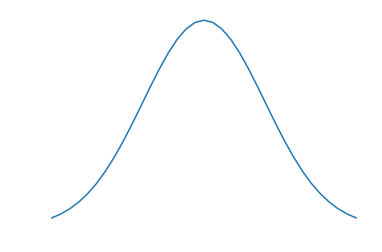

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

X = np.linspace(0, 1, 35)
norm = norm.pdf(X, 0.5, 0.2)

plt.axis('off')
plt.plot(norm)
make_openscad(X, norm, "normal.scad")
plt.savefig('norm.svg')

In [42]:
def make_openscad_hist(X, Y, filename):
    
    # open a file to store our SCAD instructions
    with open(filename, "w+") as fd:
        
        # first, we define the polygon
        # build a string containing each point of the polygon (plot) describing the distribution
        last_x = X[0]
        points = "\t[0, -0.1],\n"
        
        for x, y in zip(X, Y):
            points += "\t[{}, {}],\n".format(last_x, y)
            points += "\t[{}, {}],\n".format(x, y)
            last_x = x
            
        points += "\t[1, -0.1],\n"
        points += "\t[0, -0.1]\n"
            
            
        # write the point string to the file in SCAD format
        fd.write("""
points = [
{}];""".format(points))
        
        # next, we write SCAD instructions to turn the polygon into 3D objects and arrange them as a cookie cutter
        # - create two solid shapes from the polygon points defined above 
        # - index the first shape over to center it on origin
        # - scale up the other shape a bit and index in three dimensions to surround the smaller polygon
        # - subtract the smaller shape from the larger shape, leaving a scaled up shape with a smaller-shape hole
        # - this should give us a cookie cutter
        fd.write("""
difference(){
    
// OUTER COOKIE CUTTER SHAPE
    
    // extrude the outer polygon into a 3D shape
    // this extrusion is thinner than the inner shape to make sure the inner shape "cuts" through it completely
    linear_extrude(0.4)
    
        // x- and y-shift the outer polygon to be roughly centered around the inner shape
        // z-shift the outer polygon so the extruded inner shape cuts all the way through
        translate([-0.55, 0, -0.1])
            
            // scale this polygon up a bit to make an outer ring of a cookie cutter
            scale(1.3, 1.2, 1)
            
                // generate a polygon to become the outer shape
                polygon(points);        
    
// INNER COOKIE CUTTER SHAPE TO BE SUBTRACTED FROM OUTER

    // extrude the inner polygon into a 3D shape
    // this extrusion is thicker than the outer shape to ensure the inner shape "cuts" completey through the outer shape
    // the "scale" parameter grows the shape as it extrudes to give the finished cutter a narrower edge
    linear_extrude(0.6) 
    
        // x-shift the shape to 
        translate([-0.5, -0.012, 0]) //x-center the polygon at origin
            
            // generate a polygon to become the inner shape (this is effectively defining a hole)
            polygon(points);
}""")


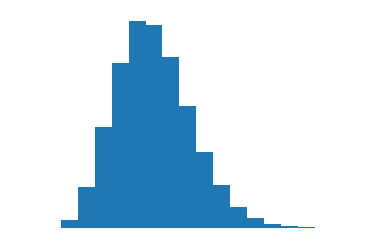

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import collections

poisson = np.random.poisson(5, 100000)
poisson_counter = collections.Counter(poisson)
pcs = sorted(poisson_counter.items(), key=lambda pair: pair[0])
X, Y = zip(*pcs)

norm_x = []
norm_y = []

for y in Y:
    norm_y.append(y / max(Y))
    
for x in X:
    norm_x.append(x / max(X))

plt.axis('off')
plt.hist(poisson, bins = len(X))
make_openscad_hist(norm_x, norm_y, "poisson.scad")
plt.savefig('poisson.svg')

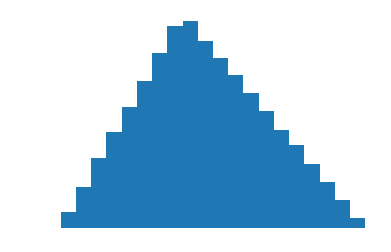

In [44]:
import numpy as np
import matplotlib.pyplot as plt

tri = np.random.triangular(0, 0.4, 1, 100000)
Y, X = np.histogram(tri, bins=19)

norm_x = []
norm_y = []

for y in Y:
    norm_y.append(y / max(Y))
    
for x in X:
    norm_x.append(x / max(X))
    
plt.axis('off')
plt.hist(tri, bins = len(X))
make_openscad_hist(norm_x, norm_y, "triangle.scad")
plt.savefig('triangle.svg')

[1 1 0 ... 1 1 1]
0.6652
[0.0, 0.5, 1.0] [0.5033072760072159, 1.0]


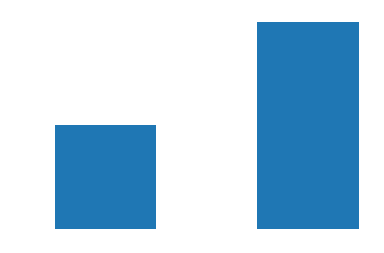

In [47]:
import numpy as np
import matplotlib.pyplot as plt

num_tests = 10000
binomial = np.random.binomial(1, 2/3, num_tests)

print(binomial)
print(sum(binomial)/num_tests)

Y, X = np.histogram(binomial, bins=2)

norm_x = []
norm_y = []

for y in Y:
    norm_y.append(y / max(Y))
    
for x in X:
    norm_x.append(x / max(X))
    
print(norm_x, norm_y)
    
plt.axis('off')
plt.hist(binomial, bins = len(X))
make_openscad_hist(norm_x, norm_y, "binomial.scad")
plt.savefig('binomial.svg')